# Analysis of spectral content before / after blurring

for experiment 14 in which I test smaller blur levels.

A bunch of this code is adapted from the [Gestalt revision](http://nbviewer.ipython.org/github/gestaltrevision/python_for_visres/blob/master/Part7/Part7_Image_Statistics.ipynb) notebook on image processing. Thanks to those guys for making this available!

In [1]:
# Import all the necessary packages
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import seaborn as sns
import data_helpers as helpers
from skimage import color, io, img_as_float
import pickle
import pandas as pd
from scipy.optimize import minimize_scalar
import psyutils as pu
from psyutils.image import show_im
from scipy.ndimage import gaussian_filter
from numpy.testing import assert_allclose
import yaml

%matplotlib inline

# set some styles we like:
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("paper")
sns.set_palette("colorblind")


In [2]:
top_dir = helpers.project_directory()
fig_dir = os.path.join(top_dir, 'figures')
code_dir = os.path.join(top_dir, 'code', 'stimuli')
im_dir = os.path.join(top_dir, 'stimuli', 'experiment-14', 'final_ims')

In [3]:
def do_fourier_transform(img):
        
    # Do the fft
    F = np.fft.fft2(img)
    
    # Center the spectrum on the lowest frequency
    F_centered = np.fft.fftshift(F)
    
    # Extract amplitude and phase
    A = np.abs(F_centered).real
    P = np.angle(F_centered).real
    
    # Return amplitude, phase, and the full spectrum
    return A, P, F


def get_band_mask(spectrum, band, n_bands):
    """Select a circular frequency band from the spectrum"""
    # Get image coordinates, and center on 0
    x,y = np.meshgrid(range(spectrum.shape[1]),range(spectrum.shape[0]))
    x = x - np.max(x)/2
    y = y - np.max(y)/2
    
    # Compute distances from center
    radius = np.hypot(x,y)
    
    # Compute the min and max frequencies of this band
    bw = np.amin(spectrum.shape)/(n_bands*2)
    freqs = [0+bw*band,bw+bw*band]
    centre_freq = np.mean(freqs)  # centre frequeny of the band
    
    # Create the corresponding mask
    msk = np.zeros(spectrum.shape, dtype=bool)
    msk[(radius<freqs[1])*(radius>freqs[0])]=True
    
    # Do not include the zero-th frequency (overall luminance)
    msk[x.shape[0]/2,y.shape[0]/2] = False
    return msk, centre_freq


def get_circ_band(spectrum, freq_range):
    """Select a circular frequency band whose frequencies are 
    given by the tuple freq_range(f_low, f_high) in pixels. 
    
    """
    # Get image coordinates, and center on 0
    x,y = np.meshgrid(range(spectrum.shape[1]),range(spectrum.shape[0]))
    x = x - np.max(x)/2
    y = y - np.max(y)/2
    
    # Compute distances from center
    radius = np.hypot(x,y)
    
    centre_freq = np.mean(freq_range)  # centre frequeny of the band
    
    # Create the corresponding mask
    msk = np.zeros(spectrum.shape, dtype=bool)
    msk[(radius<freq_range[1])*(radius>freq_range[0])]=True
    
    # Do not include the zero-th frequency (overall luminance)
    msk[x.shape[0]/2,y.shape[0]/2] = False
    return msk, centre_freq


def get_rotational_average(A, n_bands):
    """Average over the contents of n frequency bands"""
    res = []
    freq = []
    for band in np.arange(n_bands):
        msk, centre = get_band_mask(A, band, n_bands)
        res.append(np.mean(A[msk].flatten())/A.size)
        freq.append(centre)
    return (np.array(freq, dtype=float),
            np.array(res, dtype=float))

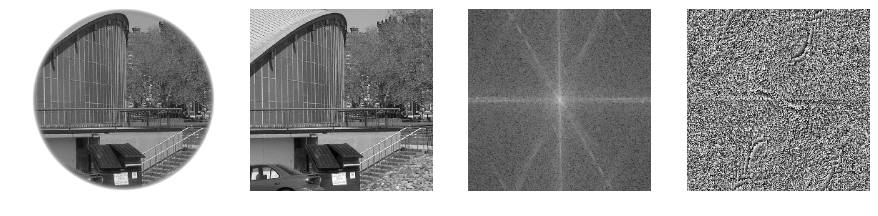

In [4]:
plt.figure(figsize=(15,5))
img = plt.imread(os.path.join(top_dir, 'stimuli', 'experiment-14', 'final_ims',
                              'i05june05_static_street_boston_p1010816_mid_nat.png'))
plt.subplot(1,4,1), plt.imshow(img), plt.axis('off')
img = color.rgb2gray(img)
plt.subplot(1,4,2), plt.imshow(img, cmap='gray'), plt.axis('off')

A, P, F = do_fourier_transform(img)

plt.subplot(1,4,3), plt.imshow(np.log(A), cmap='gray'), plt.axis('off')
plt.subplot(1,4,4), plt.imshow(P, cmap='gray'), plt.axis('off')

plt.show()

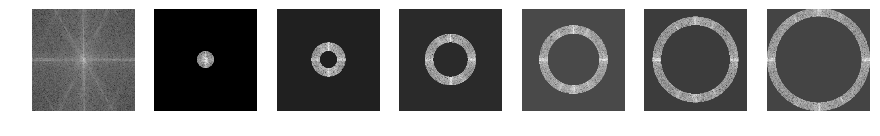

In [5]:
# illustrate band filters
n_bands = 6

plt.figure(figsize=(15,5))
plt.subplot(1, n_bands+1, 1)
plt.imshow(np.log(A),cmap='gray')
plt.axis('off')

for band in np.arange(n_bands):
    msk, freq = get_band_mask(A, band, n_bands)
    plt.subplot(1,n_bands+1,band+2)
    plt.imshow(msk*np.log(A),cmap='gray')
    plt.axis('off')

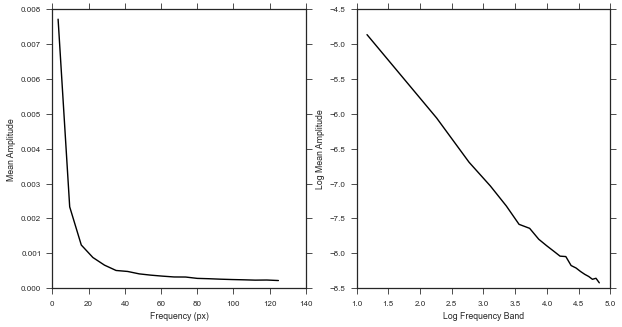

In [6]:
freq, rotavg = get_rotational_average(A, 20)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(freq, rotavg,'k-')
plt.xlabel('Frequency (px)')
plt.ylabel('Mean Amplitude')

plt.subplot(1, 2, 2)
plt.plot(np.log(freq), np.log(rotavg) ,'k-')
plt.xlabel('Log Frequency Band')
plt.ylabel('Log Mean Amplitude')

plt.show()

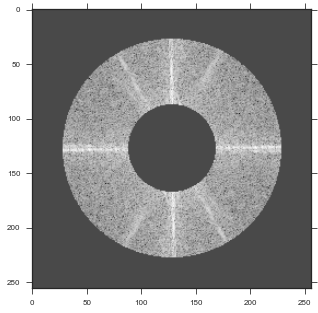

In [7]:
# illustrate a circular band specified by frequency boundaries in pix:
plt.figure(figsize=(5,5))

msk, freq = get_circ_band(A, (40, 100))
plt.imshow(msk*np.log(A),cmap='gray');
# plt.axis('off')

# For the images used in the experiment, compute spectral power



In [8]:
# load datasets
with open(os.path.join(code_dir, 'generation_params_exp_14.yaml'), 'r') as f:
    params = yaml.load(f)

im_data = pd.read_csv(os.path.join(im_dir, 'patch_info.csv'), index_col=False)
im_data.info()                       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 12 columns):
filename          100 non-null object
inner_rms         100 non-null float64
middle_rms        100 non-null float64
outer_rms         100 non-null float64
sal_inner_mean    100 non-null float64
sal_inner_sd      100 non-null float64
sal_mid_mean      100 non-null float64
sal_mid_sd        100 non-null float64
sal_outer_mean    100 non-null float64
sal_outer_sd      100 non-null float64
size              100 non-null float64
source_rms        100 non-null float64
dtypes: float64(11), object(1)
memory usage: 10.2+ KB


### Helper funcs

In [9]:
def calc_power(im, n_filts):
    a, p, s = do_fourier_transform(im)
    freq, vals = get_rotational_average(a, n_filts)    
    return freq, vals


def add_to_df(dat, x, y, blur, label):
    for i in range(len(x)):
        dat = dat.append({'im_code': im_code,
                          'blur': blur,
                          'label': label,
                          'freq': x[i],
                          'amp': y[i]}, ignore_index=True)
    return dat

### Loop

In [10]:
dat = pd.DataFrame()
n_filts = 20

for im_code in im_data['filename']:
    print(im_code)
    
    # do unblurred image
    im = io.imread(os.path.join(im_dir, '{}_mid_nat.png'.format(im_code)),
                                as_grey=True)  # loads a M x M image (discards alpha)
    
    x, y = calc_power(im, n_filts)
    dat = add_to_df(dat, x, y, blur=0, label='Original')
    
    # do blurred images
    for blur in params['blur_sigmas']:
        im = io.imread(os.path.join(im_dir, '{}_mid_blur_{}.png'.format(im_code, blur)),
                                    as_grey=True)  # loads a M x M image (discards alpha)

        x, y = calc_power(im, n_filts)
        dat = add_to_df(dat, x, y, blur=blur, label=str(blur))       

istatic_street_outdoor_palma_mallorca_spain_IMG_0714
i1130504626
i05june05_static_street_boston_p1010816
i2257986084
i2282543251
i41930076
i2295551038
i2306380490
i2305300253
istatic_boston_street_april_p1010184
i126446520
i2145575787
i2134841990
i1064999233
istatic_houses_boston_2005_IMG_4108
i2174164459
i135996473
i2244455009
i2135366103
i1156480850
i104880109
i201161868
i1248920013
i1121584164
syntheticData1
i2140171593
istatic_street_cambridge_outdoor_july_2005_img_0270
i2291666088
i111366726
istatic_coast_palafrugel_outdoor_spain_IMG_9284
i1116953942
i2069913521
i2190823731
i2303447136
syntheticData2
i2300237262
i1164346942
i2257777237
i167462665
i2312211495
i348747407
i1139671063
i1300905195
istatic_barcelona_street_city_outdoor_2005_img_0308
i179901987
i1147516428
i2280648305
i1355213079
i1539822082
i2230355522
i1247210024
i2243369152
i2289694577
i2199632150
i1817839270
i2128591182
istatic_barcelona_street_city_outdoor_2_2005_dsc04121
istatic_outdoor_urban_city_london_uk_IMG_863

In [11]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14000 entries, 0 to 13999
Data columns (total 5 columns):
amp        14000 non-null float64
blur       14000 non-null float64
freq       14000 non-null float64
im_code    14000 non-null object
label      14000 non-null object
dtypes: float64(3), object(2)
memory usage: 656.2+ KB


In [12]:
dat.head()

,amp,blur,freq,im_code,label
0,0.004815,0,3.2,istatic_street_outdoor_palma_mallorca_spain_IM...,Original
1,0.001268,0,9.6,istatic_street_outdoor_palma_mallorca_spain_IM...,Original
2,0.000689,0,16.0,istatic_street_outdoor_palma_mallorca_spain_IM...,Original
3,0.000501,0,22.4,istatic_street_outdoor_palma_mallorca_spain_IM...,Original
4,0.000359,0,28.8,istatic_street_outdoor_palma_mallorca_spain_IM...,Original


## Prepare variables for plotting

Frequency is currently expressed in pixels (radius from centre). Convert to cpd, plot on log scale.. 

In [13]:
# prepare variables:
def px_to_cpd(x):
    x = np.array(x)
    ppd = 43
    nyquist_cpi = 256 / 2
    nyquist_cpd = nyquist_cpi / (256 / ppd)
    return (x / nyquist_cpi) * nyquist_cpd


def cpd_to_px(x):
    x = np.array(x)
    ppd = 43
    nyquist_cpi = 256 / 2
    nyquist_cpd = nyquist_cpi / (256 / ppd)
    return (x / nyquist_cpd) * nyquist_cpi

In [14]:
dat['freq'].describe()

count    14000.000000
mean        64.000000
std         36.905518
min          3.200000
25%         33.600000
50%         64.000000
75%         94.400000
max        124.800000
Name: freq, dtype: float64

In [15]:
# prepare variables:
dat.loc[:, 'freq_cpd'] = px_to_cpd(dat.loc[:, 'freq'])
dat.loc[:, 'log_freq_cpd'] = np.log10(dat.loc[:, 'freq_cpd'])
dat.loc[:, 'log_amp'] = np.log10(dat.loc[:, 'amp'])

In [16]:
dat['freq_cpd'].describe()

count    14000.000000
mean        10.750000
std          6.198974
min          0.537500
25%          5.643750
50%         10.750000
75%         15.856250
max         20.962500
Name: freq_cpd, dtype: float64

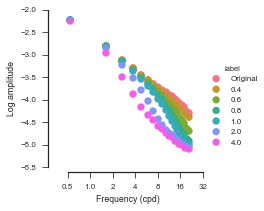

In [17]:
g = sns.lmplot('log_freq_cpd', 'log_amp', dat,
               hue='label',
               x_estimator=np.mean,
               size=3,
               fit_reg=False)
# g.set_xticklabels(np.array([-0.5, 0, 0.5, 1., 1.5])**10)
g.set(xticks=np.log10(np.array([0.5, 1., 2, 4, 8, 16, 32])))
g.set_xticklabels([0.5, 1., 2, 4, 8, 16, 32])
g.set_axis_labels("Frequency (cpd)", "Log amplitude")
g.despine(offset=5, trim=True);


### Replot as average line, with subplot for attenuations

In [18]:
# compute average amplitudes over images:
avs = dat.groupby(['log_freq_cpd', 'label']).log_amp.mean() 
avs = avs.reset_index()

avs.head()

,log_freq_cpd,label,log_amp
0,-0.269622,0.4,-2.234955
1,-0.269622,0.6,-2.235362
2,-0.269622,0.8,-2.235778
3,-0.269622,1.0,-2.236309
4,-0.269622,2.0,-2.240620


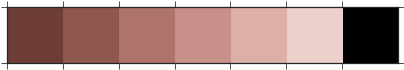

In [19]:
pal = sns.cubehelix_palette(n_colors=6, start=4, rot=0, gamma=1.0, hue=0.8, light=0.85, dark=0.3, reverse=True)
pal.append([0, 0, 0])
# sns.set_palette(sns.color_palette("cubehelix", 5))
sns.palplot(pal)
sns.set_palette(pal)

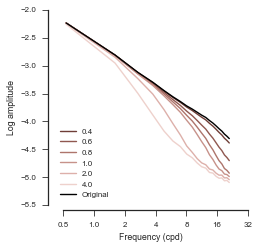

In [20]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

for l in np.unique(avs['label']):
    plt.plot(avs.loc[avs['label'] == l, 'log_freq_cpd'],
             avs.loc[avs['label'] == l, 'log_amp'],
             label=l)
    
ax.set(xticks=np.log10(np.array([0.5, 1., 2, 4, 8, 16, 32])))
ax.set_xticklabels([0.5, 1., 2, 4, 8, 16, 32])
plt.xlabel("Frequency (cpd)")
plt.ylabel("Log amplitude")
plt.legend(loc='lower left')
sns.despine(offset=5, trim=True);
plt.savefig(os.path.join(fig_dir,'expt_14_spectral_content.pdf'), bbox_inches='tight')